# 02 - ML Experimentation with Custom Model

The purpose of this notebook is to use [custom training](https://cloud.google.com/ai-platform-unified/docs/training/custom-training) to train a keras classifier to predict whether a given trip will result in a tip > 20%. The notebook covers the following tasks:
1. Preprocess the data locally using Apache Beam.
2. Train and test custom model locally using a Keras implementation.
3. Submit a Dataflow job to preprocess the data at scale.
4. Submit a custom training job to Vertex AI using a [pre-built container](https://cloud.google.com/ai-platform-unified/docs/training/pre-built-containers).
5. Upload the trained model to Vertex AI.
6. Track experiment parameters from [Vertex AI Metadata](https://cloud.google.com/vertex-ai/docs/ml-metadata/introduction).
7. Submit a [hyperparameter tuning job](https://cloud.google.com/vertex-ai/docs/training/hyperparameter-tuning-overview) to Vertex AI.

We use [Vertex TensorBoard](https://cloud.google.com/vertex-ai/docs/experiments/tensorboard-overview) 
and [Vertex ML Metadata](https://cloud.google.com/vertex-ai/docs/ml-metadata/introduction) to  track, visualize, and compare ML experiments.

## Setup

### Import libraries

In [1]:
import os
import logging
from datetime import datetime
import numpy as np

import tensorflow as tf
import tensorflow_transform as tft
import tensorflow.keras as keras

from google.cloud import aiplatform as vertex_ai
from google.cloud.aiplatform import hyperparameter_tuning as hp_tuning

from src.common import features, datasource_utils
from src.model_training import data, model, defaults, trainer, exporter
from src.preprocessing import etl

logging.getLogger().setLevel(logging.INFO)
tf.get_logger().setLevel('INFO')

print(f"TensorFlow: {tf.__version__}")
print(f"TensorFlow Transform: {tft.__version__}")

2023-03-27 22:39:34.950916: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-27 22:39:34.950970: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TensorFlow: 2.8.4
TensorFlow Transform: 1.8.0


### Setup Google Cloud project

In [2]:
PROJECT = '[your-project-id]' # Change to your project id.
REGION = 'us-central1' # Change to your region.
SERVICE_ACCOUNT = None
BUCKET = None

if PROJECT == "" or PROJECT is None or PROJECT == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT = shell_output[0]
    
if SERVICE_ACCOUNT == "" or SERVICE_ACCOUNT is None or SERVICE_ACCOUNT == "[your-service-account]":
    # Get your GCP project id from gcloud
    shell_output = !gcloud config list --format 'value(core.account)' 2>/dev/null
    SERVICE_ACCOUNT = shell_output[0]
    
if BUCKET == "" or BUCKET is None or BUCKET == "[your-bucket-name]":
    # Get your bucket name to GCP project id
    BUCKET = PROJECT
    # Try to create the bucket if it doesn'exists
    ! gsutil mb -l $REGION gs://$BUCKET
    print("")
    
PARENT = f"projects/{PROJECT}/locations/{REGION}"
    
print("Project ID:", PROJECT)
print("Region:", REGION)
print("Bucket name:", BUCKET)
print("Service Account:", SERVICE_ACCOUNT)
print("Vertex API Parent URI:", PARENT)

Creating gs://ds-training-380514/...
ServiceException: 409 A Cloud Storage bucket named 'ds-training-380514' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.

Project ID: ds-training-380514
Region: us-central1
Bucket name: ds-training-380514
Service Account: 354621994428-compute@developer.gserviceaccount.com
Vertex API Parent URI: projects/ds-training-380514/locations/us-central1


### Set configurations

In [3]:
VERSION = 'v01'
DATASET_DISPLAY_NAME = 'chicago-taxi-tips'
MODEL_DISPLAY_NAME = f'{DATASET_DISPLAY_NAME}-classifier-{VERSION}'

WORKSPACE = f'gs://{BUCKET}/{DATASET_DISPLAY_NAME}'
EXPERIMENT_ARTIFACTS_DIR = os.path.join(WORKSPACE, 'experiments')
RAW_SCHEMA_LOCATION = 'src/raw_schema/schema.pbtxt'

TENSORBOARD_DISPLAY_NAME = f'tb-{DATASET_DISPLAY_NAME}'
EXPERIMENT_NAME = f'{MODEL_DISPLAY_NAME}'

## Create Vertex TensorBoard instance 

In [4]:
tensorboard_resource = vertex_ai.Tensorboard.create(display_name=TENSORBOARD_DISPLAY_NAME)
tensorboard_resource_name = tensorboard_resource.gca_resource.name
print("TensorBoard resource name:", tensorboard_resource_name)

Creating Tensorboard
Create Tensorboard backing LRO: projects/354621994428/locations/us-central1/tensorboards/8667151094595452928/operations/5202561162012524544
Tensorboard created. Resource name: projects/354621994428/locations/us-central1/tensorboards/8667151094595452928
To use this Tensorboard in another session:
tb = aiplatform.Tensorboard('projects/354621994428/locations/us-central1/tensorboards/8667151094595452928')
TensorBoard resource name: projects/354621994428/locations/us-central1/tensorboards/8667151094595452928


## Initialize workspace

In [5]:
REMOVE_EXPERIMENT_ARTIFACTS = False

if tf.io.gfile.exists(EXPERIMENT_ARTIFACTS_DIR) and REMOVE_EXPERIMENT_ARTIFACTS:
    print("Removing previous experiment artifacts...")
    tf.io.gfile.rmtree(EXPERIMENT_ARTIFACTS_DIR)

if not tf.io.gfile.exists(EXPERIMENT_ARTIFACTS_DIR):
    print("Creating new experiment artifacts directory...")
    tf.io.gfile.mkdir(EXPERIMENT_ARTIFACTS_DIR)

print("Workspace is ready.")
print("Experiment directory:", EXPERIMENT_ARTIFACTS_DIR)

Workspace is ready.
Experiment directory: gs://ds-training-380514/chicago-taxi-tips/experiments


## Initialize Vertex AI experiment

In [6]:
vertex_ai.init(
    project=PROJECT,
    location=REGION,
    staging_bucket=BUCKET,
    experiment=EXPERIMENT_NAME
)

run_id = f"run-local-{datetime.now().strftime('%Y%m%d%H%M%S')}"
vertex_ai.start_run(run_id)

EXPERIMENT_RUN_DIR = os.path.join(EXPERIMENT_ARTIFACTS_DIR, EXPERIMENT_NAME, run_id)
print("Experiment run directory:", EXPERIMENT_RUN_DIR)

Associating projects/354621994428/locations/us-central1/metadataStores/default/contexts/chicago-taxi-tips-classifier-v01-run-local-20230327223943 to Experiment: chicago-taxi-tips-classifier-v01
Experiment run directory: gs://ds-training-380514/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01/run-local-20230327223943


## 1. Preprocess the data using Apache Beam

The Apache Beam pipeline of data preprocessing is implemented in the [preprocessing](src/preprocessing) directory.

In [7]:
EXPORTED_DATA_PREFIX = os.path.join(EXPERIMENT_RUN_DIR, 'exported_data')
TRANSFORMED_DATA_PREFIX = os.path.join(EXPERIMENT_RUN_DIR, 'transformed_data')
TRANSFORM_ARTIFACTS_DIR = os.path.join(EXPERIMENT_RUN_DIR, 'transform_artifacts')

In [8]:
print(f"EXPORTED_DATA_PREFIX={EXPORTED_DATA_PREFIX}")
print(f"TRANSFORMED_DATA_PREFIX={TRANSFORMED_DATA_PREFIX}")
print(f"TRANSFORM_ARTIFACTS_DIR= {TRANSFORM_ARTIFACTS_DIR}")

EXPORTED_DATA_PREFIX=gs://ds-training-380514/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01/run-local-20230327223943/exported_data
TRANSFORMED_DATA_PREFIX=gs://ds-training-380514/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01/run-local-20230327223943/transformed_data
TRANSFORM_ARTIFACTS_DIR= gs://ds-training-380514/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01/run-local-20230327223943/transform_artifacts


### Get Source Query from Managed Dataset

In [9]:
ML_USE = 'UNASSIGNED'
LIMIT = 5120

raw_data_query = datasource_utils.get_training_source_query(
    project=PROJECT, 
    region=REGION, 
    dataset_display_name=DATASET_DISPLAY_NAME, 
    ml_use=ML_USE, 
    limit=LIMIT
)

print(raw_data_query)


    SELECT 
        IF(trip_month IS NULL, -1, trip_month) trip_month,
        IF(trip_day IS NULL, -1, trip_day) trip_day,
        IF(trip_day_of_week IS NULL, -1, trip_day_of_week) trip_day_of_week,
        IF(trip_hour IS NULL, -1, trip_hour) trip_hour,
        IF(trip_seconds IS NULL, -1, trip_seconds) trip_seconds,
        IF(trip_miles IS NULL, -1, trip_miles) trip_miles,
        IF(payment_type IS NULL, 'NA', payment_type) payment_type,
        IF(pickup_grid IS NULL, 'NA', pickup_grid) pickup_grid,
        IF(dropoff_grid IS NULL, 'NA', dropoff_grid) dropoff_grid,
        IF(euclidean IS NULL, -1, euclidean) euclidean,
        IF(loc_cross IS NULL, 'NA', loc_cross) loc_cross,
        tip_bin
    FROM playground_us.chicago_taxitrips_prep 
    WHERE ML_use = 'UNASSIGNED'
    LIMIT 5120


### Test Data Preprocessing Locally

In [10]:
args = {
    'runner': 'DirectRunner',
    'raw_data_query': raw_data_query,
    'write_raw_data': True,
    'exported_data_prefix': EXPORTED_DATA_PREFIX,
    'transformed_data_prefix': TRANSFORMED_DATA_PREFIX,
    'transform_artifact_dir': TRANSFORM_ARTIFACTS_DIR,
    'temporary_dir': os.path.join(WORKSPACE, 'tmp'),
    'gcs_location': f'gs://{BUCKET}/bq_tmp',
    'project': PROJECT
}

In [11]:
vertex_ai.log_params(args)

In [12]:
%%capture
print("Data preprocessing started...")
etl.run_transform_pipeline(args)
print("Data preprocessing completed.")

Instructions for updating:
Use ref() instead.


2023-03-27 22:39:44.723973: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-27 22:39:44.724022: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-27 22:39:44.724046: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bobby-jacob-mavenwave): /proc/driver/nvidia/version does not exist
2023-03-27 22:39:44.724486: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-03-27 22:40:21.084451: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: gs://ds-training-380514/chicago-taxi-tips/tmp/tftransform_tmp/94724cfac0ae40f8bc25aed653739aa6/assets
INFO:tensorflow:struct2tensor is not available.
INFO:tensorflow:tensorflow_decision_forests is not available.
INFO:tensorflow:tensorflow_text is not available.
INFO:tensorflow:Assets written to: gs://ds-training-380514/chicago-taxi-tips/tmp/tftransform_tmp/ac003dadc184454cbb6c4b552c108eb3/assets
INFO:tensorflow:struct2tensor is not available.
INFO:tensorflow:tensorflow_decision_forests is not available.
INFO:tensorflow:tensorflow_text is not available.
INFO:tensorflow:struct2tensor is not available.
INFO:tensorflow:tensorflow_decision_forests is not available.
INFO:tensorflow:tensorflow_text is not available.


In [13]:
!gsutil ls {EXPERIMENT_RUN_DIR}

gs://ds-training-380514/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01/run-local-20230327223943/exported_data/
gs://ds-training-380514/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01/run-local-20230327223943/transform_artifacts/
gs://ds-training-380514/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01/run-local-20230327223943/transformed_data/


## 2. Train a custom model locally using a Keras

The `Keras` implementation of the custom model is in the [model_training](src/model_training) directory.

In [14]:
LOG_DIR = os.path.join(EXPERIMENT_RUN_DIR, 'logs')
EXPORT_DIR = os.path.join(EXPERIMENT_RUN_DIR, 'model')

In [15]:
print(LOG_DIR)
print(EXPORT_DIR)

gs://ds-training-380514/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01/run-local-20230327223943/logs
gs://ds-training-380514/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01/run-local-20230327223943/model


### Read transformed data

In [16]:
tft_output = tft.TFTransformOutput(TRANSFORM_ARTIFACTS_DIR)
transform_feature_spec = tft_output.transformed_feature_spec()
transform_feature_spec

{'dropoff_grid_xf': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'euclidean_xf': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 'loc_cross_xf': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'payment_type_xf': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'pickup_grid_xf': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'tip_bin': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'trip_day_of_week_xf': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'trip_day_xf': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'trip_hour_xf': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'trip_miles_xf': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 'trip_month_xf': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'trip_seconds_xf': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None)}

In [17]:
train_data_file_pattern = os.path.join(TRANSFORMED_DATA_PREFIX,'train/data-*.gz')
eval_data_file_pattern = os.path.join(TRANSFORMED_DATA_PREFIX,'eval/data-*.gz')

for input_features, target in data.get_dataset(
    train_data_file_pattern, transform_feature_spec, batch_size=3).take(1):
    for key in input_features:
        print(f"{key} {input_features[key].dtype}: {input_features[key].numpy().tolist()}")
    print(f"target: {target.numpy().tolist()}")

dropoff_grid_xf <dtype: 'int64'>: [0, 0, 0]
euclidean_xf <dtype: 'float32'>: [-0.846295952796936, 0.5646443963050842, 0.6452082395553589]
loc_cross_xf <dtype: 'int64'>: [0, 0, 0]
payment_type_xf <dtype: 'int64'>: [0, 0, 0]
pickup_grid_xf <dtype: 'int64'>: [0, 0, 0]
trip_day_of_week_xf <dtype: 'int64'>: [0, 4, 4]
trip_day_xf <dtype: 'int64'>: [9, 24, 21]
trip_hour_xf <dtype: 'int64'>: [21, 20, 11]
trip_miles_xf <dtype: 'float32'>: [0.4045217037200928, -0.30162057280540466, -0.174350768327713]
trip_month_xf <dtype: 'int64'>: [0, 1, 1]
trip_seconds_xf <dtype: 'float32'>: [0.22258223593235016, -0.19465206563472748, -0.18432681262493134]
target: [0, 0, 0]


### Create hyperparameters

In [18]:
hyperparams = {
    "hidden_units": [64, 32]
}

hyperparams = defaults.update_hyperparams(hyperparams)
hyperparams

{'hidden_units': [64, 32],
 'learning_rate': 0.0001,
 'batch_size': 512,
 'num_epochs': 10}

### Create and test model inputs and outputs

In [19]:
classifier = model.create_binary_classifier(tft_output, hyperparams)
classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 trip_month_xf (InputLayer)     [(None,)]            0           []                               
                                                                                                  
 trip_day_xf (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 trip_day_of_week_xf (InputLaye  [(None,)]           0           []                               
 r)                                                                                               
                                                                                                  
 trip_hour_xf (InputLayer)      [(None,)]            0           []                           

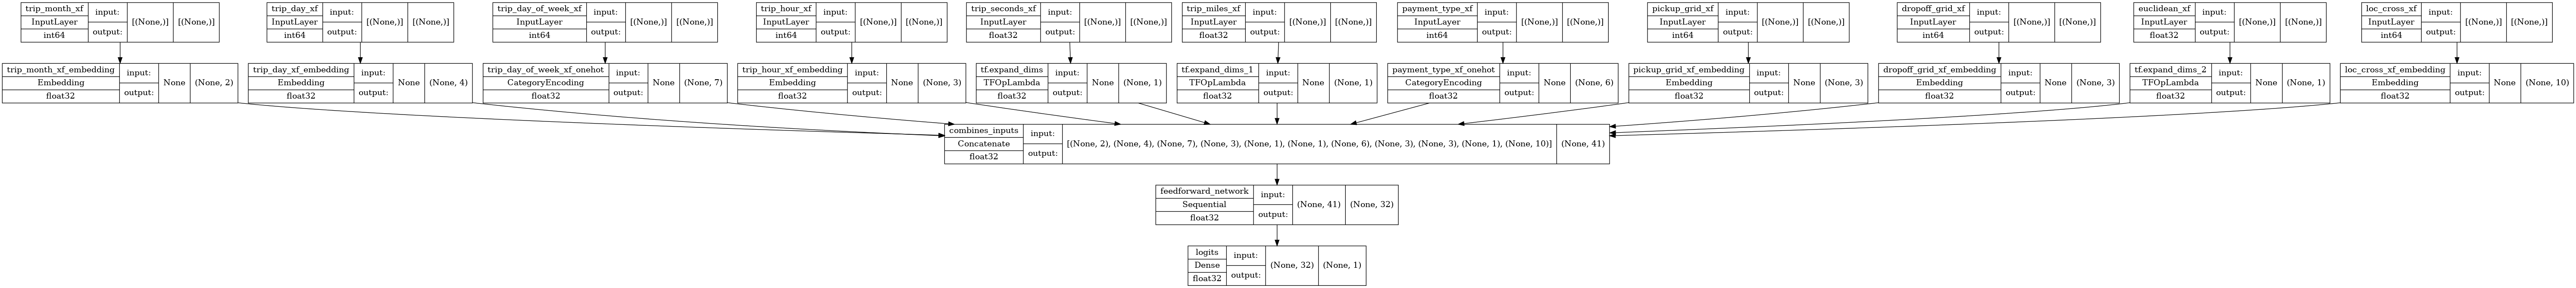

In [20]:
keras.utils.plot_model(
    classifier, 
    show_shapes=True, 
    show_dtype=True
)

In [21]:
classifier(input_features)

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[ 0.11148095],
       [-0.06537776],
       [-0.06502326]], dtype=float32)>

### Train the model locally.

In [22]:
logging.getLogger().setLevel(logging.INFO)

hyperparams["learning_rate"] = 0.001
hyperparams["num_epochs"] = 5
hyperparams["batch_size"] = 512

# vertex_ai.log_params(hyperparams)

In [23]:
classifier = trainer.train(
    train_data_dir=train_data_file_pattern,
    eval_data_dir=eval_data_file_pattern,
    tft_output_dir=TRANSFORM_ARTIFACTS_DIR,
    hyperparams=hyperparams,
    log_dir=LOG_DIR,
)

Epoch 1/5
7/7 [==============================] - 3s 284ms/step - loss: 0.5632 - accuracy: 0.8892 - val_loss: 0.5017 - val_accuracy: 0.9043
Epoch 2/5
7/7 [==============================] - 1s 104ms/step - loss: 0.4735 - accuracy: 0.8917 - val_loss: 0.4164 - val_accuracy: 0.9053
Epoch 3/5
7/7 [==============================] - 1s 103ms/step - loss: 0.4009 - accuracy: 0.8915 - val_loss: 0.3488 - val_accuracy: 0.9033
Epoch 4/5
7/7 [==============================] - 1s 116ms/step - loss: 0.3433 - accuracy: 0.8903 - val_loss: 0.2917 - val_accuracy: 0.9053
Epoch 5/5
7/7 [==============================] - 1s 101ms/step - loss: 0.2967 - accuracy: 0.8917 - val_loss: 0.2547 - val_accuracy: 0.9043


In [24]:
val_loss, val_accuracy = trainer.evaluate(
    model=classifier,
    data_dir=eval_data_file_pattern,
    raw_schema_location=RAW_SCHEMA_LOCATION,
    tft_output_dir=TRANSFORM_ARTIFACTS_DIR,
    hyperparams=hyperparams,
)

2/2 [==============================] - 0s 26ms/step - loss: 0.2525 - accuracy: 0.9053


In [25]:
vertex_ai.log_metrics(
    {"val_loss": val_loss, "val_accuracy": val_accuracy})

In [26]:
!tb-gcp-uploader --tensorboard_resource_name={tensorboard_resource_name} \
  --logdir={LOG_DIR} \
  --experiment_name={EXPERIMENT_NAME} --one_shot=True

2023-03-27 22:41:40.313176: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-27 22:41:40.313230: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-27 22:41:42.181958: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-27 22:41:42.182015: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-27 22:41:42.182042: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bobby-jacob-mavenwave): /proc/driver/nvidia/version does not exist
View your Tensorboard at https://us-central1.tensorboar

### Export the trained model

In [27]:
saved_model_dir = os.path.join(EXPORT_DIR)

exporter.export_serving_model(
    classifier=classifier,
    serving_model_dir=saved_model_dir,
    raw_schema_location=RAW_SCHEMA_LOCATION,
    tft_output_dir=TRANSFORM_ARTIFACTS_DIR,
)

INFO:tensorflow:struct2tensor is not available.
INFO:tensorflow:tensorflow_decision_forests is not available.
INFO:tensorflow:tensorflow_text is not available.
INFO:tensorflow:Assets written to: gs://ds-training-380514/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01/run-local-20230327223943/model/assets


### Inspect model serving signatures

In [28]:
!saved_model_cli show --dir={saved_model_dir} --tag_set=serve --signature_def=serving_tf_example

2023-03-27 22:43:00.337501: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-27 22:43:00.337551: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
The given SavedModel SignatureDef contains the following input(s):
  inputs['examples'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_tf_example_examples:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['probabilities'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: StatefulPartitionedCall_41:0
Method name is: tensorflow/serving/predict


In [29]:
!saved_model_cli show --dir={saved_model_dir} --tag_set=serve --signature_def=serving_default

2023-03-27 22:43:03.700854: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-27 22:43:03.700903: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
The given SavedModel SignatureDef contains the following input(s):
  inputs['dropoff_grid'] tensor_info:
      dtype: DT_STRING
      shape: (-1, 1)
      name: serving_default_dropoff_grid:0
  inputs['euclidean'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_euclidean:0
  inputs['loc_cross'] tensor_info:
      dtype: DT_STRING
      shape: (-1, 1)
      name: serving_default_loc_cross:0
  inputs['payment_type'] tensor_info:
      dtype: DT_STRING
      shape: (-1, 1)
      name: serving_default_payment_type:0
  inputs['pickup_grid'] tensor_info:
      dtype: DT_STRIN

### Test the exported SavedModel

In [30]:
serving_model = tf.saved_model.load(saved_model_dir)
print("Saved model is loaded.")

Saved model is loaded.


In [31]:
# Test the serving_tf_example with TF Examples

file_names = tf.data.TFRecordDataset.list_files(EXPORTED_DATA_PREFIX + '/data-*.tfrecord')
for batch in tf.data.TFRecordDataset(file_names).batch(3).take(1):
    predictions = serving_model.signatures['serving_tf_example'](batch)
    for key in predictions:
        print(f"{key}: {predictions[key]}")

probabilities: [[0.10981545]
 [0.07959303]
 [0.10693768]]


In [32]:
# Test the serving_default with feature dictionary

import tensorflow_data_validation as tfdv
from tensorflow_transform.tf_metadata import schema_utils

raw_schema = tfdv.load_schema_text(RAW_SCHEMA_LOCATION)
raw_feature_spec = schema_utils.schema_as_feature_spec(raw_schema).feature_spec

In [33]:
instance = {
    "dropoff_grid": "POINT(-87.6 41.9)",
    "euclidean": 2064.2696,
    "loc_cross": "",
    "payment_type": "Credit Card",
    "pickup_grid": "POINT(-87.6 41.9)",
    "trip_miles": 1.37,
    "trip_day": 12,
    "trip_hour": 6,
    "trip_month": 2,
    "trip_day_of_week": 4,
    "trip_seconds": 555,
}

for feature_name in instance:
    dtype = raw_feature_spec[feature_name].dtype
    instance[feature_name] = tf.constant([[instance[feature_name]]], dtype)

In [34]:
predictions = serving_model.signatures['serving_default'](**instance)
for key in predictions:
    print(f"{key}: {predictions[key].numpy()}")

scores: [[0.2756467 0.7243533]]
classes: [[b'tip<20%' b'tip>=20%']]


## Start a new Vertex AI experiment run

In [35]:
vertex_ai.init(
    project=PROJECT,
    staging_bucket=BUCKET,
    experiment=EXPERIMENT_NAME)

run_id = f"run-gcp-{datetime.now().strftime('%Y%m%d%H%M%S')}"
vertex_ai.start_run(run_id)

EXPERIMENT_RUN_DIR = os.path.join(EXPERIMENT_ARTIFACTS_DIR, EXPERIMENT_NAME, run_id)
print("Experiment run directory:", EXPERIMENT_RUN_DIR)

Associating projects/354621994428/locations/us-central1/metadataStores/default/contexts/chicago-taxi-tips-classifier-v01-run-gcp-20230327224312 to Experiment: chicago-taxi-tips-classifier-v01
Experiment run directory: gs://ds-training-380514/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01/run-gcp-20230327224312


## 3. Submit a Data Processing Job to Dataflow

In [36]:
# EXPORTED_DATA_PREFIX = os.path.join(EXPERIMENT_RUN_DIR, 'exported_data')
# TRANSFORMED_DATA_PREFIX = os.path.join(EXPERIMENT_RUN_DIR, 'transformed_data')
# TRANSFORM_ARTIFACTS_DIR = os.path.join(EXPERIMENT_RUN_DIR, 'transform_artifacts')

In [37]:
# ML_USE = 'UNASSIGNED'
# # LIMIT = 1000000
# LIMIT = 10000
# raw_data_query = datasource_utils.get_training_source_query(
#     project=PROJECT, 
#     region=REGION, 
#     dataset_display_name=DATASET_DISPLAY_NAME, 
#     ml_use=ML_USE, 
#     limit=LIMIT
# )

# etl_job_name = f"etl-{MODEL_DISPLAY_NAME}-{run_id}"

# args = {
#     'job_name': etl_job_name,
#     'runner': 'DataflowRunner',
#     'raw_data_query': raw_data_query,
#     'exported_data_prefix': EXPORTED_DATA_PREFIX,
#     'transformed_data_prefix': TRANSFORMED_DATA_PREFIX,
#     'transform_artifact_dir': TRANSFORM_ARTIFACTS_DIR,
#     'write_raw_data': False,
#     'temporary_dir': os.path.join(WORKSPACE, 'tmp'),
#     'gcs_location': os.path.join(WORKSPACE, 'bq_tmp'),
#     'project': PROJECT,
#     'region': REGION,
#     'setup_file': './setup.py',
#     'no_use_public_ips': True
# }

In [38]:
# vertex_ai.log_params(args)

In [39]:
# logging.getLogger().setLevel(logging.ERROR)

# print("Data preprocessing started...")
# etl.run_transform_pipeline(args)
# print("Data preprocessing completed.")

In [40]:
# !gsutil ls {EXPERIMENT_RUN_DIR}

## 4. Submit a Custom Training Job to Vertex AI

In [41]:
# Fix this error:
# ImportError: /lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.30' not found
LD_LIBRARY_PATH = f'/opt/conda/lib/'
os.environ["LD_LIBRARY_PATH"] = LD_LIBRARY_PATH

In [42]:
LOG_DIR = os.path.join(EXPERIMENT_RUN_DIR, 'logs')
EXPORT_DIR = os.path.join(EXPERIMENT_RUN_DIR, 'model')

In [43]:
print(LOG_DIR, "\n", EXPORT_DIR)

gs://ds-training-380514/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01/run-gcp-20230327224312/logs 
 gs://ds-training-380514/chicago-taxi-tips/experiments/chicago-taxi-tips-classifier-v01/run-gcp-20230327224312/model


### Test the training task locally

In [44]:
!python -m src.model_training.task \
    --model-dir={EXPORT_DIR} \
    --log-dir={LOG_DIR} \
    --train-data-dir={TRANSFORMED_DATA_PREFIX}/train/* \
    --eval-data-dir={TRANSFORMED_DATA_PREFIX}/eval/*  \
    --tft-output-dir={TRANSFORM_ARTIFACTS_DIR} \
    --num-epochs=3 \
    --hidden-units=32,32 \
    --experiment-name={EXPERIMENT_NAME} \
    --run-name={run_id} \
    --project={PROJECT} \
    --region={REGION} \
    --staging-bucket={BUCKET}

2023-03-27 22:43:13.702144: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/
2023-03-27 22:43:13.702193: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
INFO:root:Python Version = 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) 
[GCC 9.4.0]
INFO:root:TensorFlow Version = 2.8.4
INFO:root:TF_CONFIG = Not found
2023-03-27 22:43:17.854337: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 22:43:17.855708: W tensorflow/stream_executor/pl

### Prepare training package

In [45]:
TRAINER_PACKAGE_DIR = os.path.join(WORKSPACE, 'trainer_packages')
TRAINER_PACKAGE_NAME = f'{MODEL_DISPLAY_NAME}_trainer'
print("Trainer package upload location:", TRAINER_PACKAGE_DIR)

Trainer package upload location: gs://ds-training-380514/chicago-taxi-tips/trainer_packages


In [46]:
!rm -r src/*/__pycache__/
!rm -r src/*/.ipynb_checkpoints/
!rm -f {TRAINER_PACKAGE_NAME}.tar {TRAINER_PACKAGE_NAME}.tar.gz

!mkdir {TRAINER_PACKAGE_NAME}

!cp setup.py {TRAINER_PACKAGE_NAME}/
!cp -r src {TRAINER_PACKAGE_NAME}/
!tar cvf {TRAINER_PACKAGE_NAME}.tar {TRAINER_PACKAGE_NAME}
!gzip {TRAINER_PACKAGE_NAME}.tar
!gsutil cp {TRAINER_PACKAGE_NAME}.tar.gz {TRAINER_PACKAGE_DIR}/
!rm -r {TRAINER_PACKAGE_NAME}
!rm -r {TRAINER_PACKAGE_NAME}.tar.gz

rm: cannot remove 'src/*/.ipynb_checkpoints/': No such file or directory
chicago-taxi-tips-classifier-v01_trainer/
chicago-taxi-tips-classifier-v01_trainer/src/
chicago-taxi-tips-classifier-v01_trainer/src/tfx_pipelines/
chicago-taxi-tips-classifier-v01_trainer/src/tfx_pipelines/prediction_pipeline.py
chicago-taxi-tips-classifier-v01_trainer/src/tfx_pipelines/training_pipeline.py
chicago-taxi-tips-classifier-v01_trainer/src/tfx_pipelines/config.py
chicago-taxi-tips-classifier-v01_trainer/src/tfx_pipelines/components.py
chicago-taxi-tips-classifier-v01_trainer/src/tfx_pipelines/__init__.py
chicago-taxi-tips-classifier-v01_trainer/src/tfx_pipelines/runner.py
chicago-taxi-tips-classifier-v01_trainer/src/preprocessing/
chicago-taxi-tips-classifier-v01_trainer/src/preprocessing/etl.py
chicago-taxi-tips-classifier-v01_trainer/src/preprocessing/transformations.py
chicago-taxi-tips-classifier-v01_trainer/src/preprocessing/__init__.py
chicago-taxi-tips-classifier-v01_trainer/src/pipeline_trigge

### Prepare the training job

In [47]:
# Note: Training runtime is spelled 'tf-cpu.*" while in later notebooks, serving runtime is spelled 'tf2-cpu.*"
TRAIN_RUNTIME = 'tf-cpu.2-8'
TRAIN_IMAGE = f"us-docker.pkg.dev/vertex-ai/training/{TRAIN_RUNTIME}:latest"
print("Training image:", TRAIN_IMAGE)

Training image: us-docker.pkg.dev/vertex-ai/training/tf-cpu.2-8:latest


In [48]:
num_epochs = 2
learning_rate = 0.001
hidden_units = "64,64"

trainer_args = [
    f'--train-data-dir={TRANSFORMED_DATA_PREFIX + "/train/*"}',
    f'--eval-data-dir={TRANSFORMED_DATA_PREFIX + "/eval/*"}',
    f'--tft-output-dir={TRANSFORM_ARTIFACTS_DIR}',
    f'--num-epochs={num_epochs}',
    f'--learning-rate={learning_rate}',
    f'--project={PROJECT}',
    f'--region={REGION}',
    f'--staging-bucket={BUCKET}',
    f'--experiment-name={EXPERIMENT_NAME}'
]

In [49]:
package_uri = os.path.join(TRAINER_PACKAGE_DIR, f'{TRAINER_PACKAGE_NAME}.tar.gz')

worker_pool_specs = [
    {
        "replica_count": 1,
        "machine_spec": {
            "machine_type": 'n1-standard-4',
            "accelerator_count": 0
    },
        "python_package_spec": {
            "executor_image_uri": TRAIN_IMAGE,
            "package_uris": [package_uri],
            "python_module": "src.model_training.task",
            "args": trainer_args,
        }
    }
]

### Submit the training job

In [50]:
# print("Submitting a custom training job...")

# training_job_display_name = f"{TRAINER_PACKAGE_NAME}_{run_id}"

# training_job = vertex_ai.CustomJob(
#     display_name=training_job_display_name,
#     worker_pool_specs=worker_pool_specs,
#     base_output_dir=EXPERIMENT_RUN_DIR,
# )

# training_job.run(
#     service_account=SERVICE_ACCOUNT,
#     tensorboard=tensorboard_resource_name,
#     sync=True
# )

Submitting a custom training job...
Creating CustomJob
CustomJob created. Resource name: projects/354621994428/locations/us-central1/customJobs/2464840774366265344
To use this CustomJob in another session:
custom_job = aiplatform.CustomJob.get('projects/354621994428/locations/us-central1/customJobs/2464840774366265344')
View Custom Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/2464840774366265344?project=354621994428
View Tensorboard:
https://us-central1.tensorboard.googleusercontent.com/experiment/projects+354621994428+locations+us-central1+tensorboards+8667151094595452928+experiments+2464840774366265344
CustomJob projects/354621994428/locations/us-central1/customJobs/2464840774366265344 current state:
JobState.JOB_STATE_PENDING
CustomJob projects/354621994428/locations/us-central1/customJobs/2464840774366265344 current state:
JobState.JOB_STATE_PENDING
CustomJob projects/354621994428/locations/us-central1/customJobs/2464840774366265344 current state

RuntimeError: Job failed with:
code: 3
message: "The replica workerpool0-0 exited with a non-zero status of 1. \nTraceback (most recent call last):\n  File \"/opt/conda/lib/python3.7/runpy.py\", line 193, in _run_module_as_main\n    \"__main__\", mod_spec)\n  File \"/opt/conda/lib/python3.7/runpy.py\", line 85, in _run_code\n    exec(code, run_globals)\n  File \"/root/.local/lib/python3.7/site-packages/src/model_training/task.py\", line 27, in <module>\n    from src.model_training import defaults, trainer, exporter\n  File \"/root/.local/lib/python3.7/site-packages/src/model_training/trainer.py\", line 18, in <module>\n    import tensorflow_transform as tft\n  File \"/opt/conda/lib/python3.7/site-packages/tensorflow_transform/__init__.py\", line 19, in <module>\n    from tensorflow_transform.analyzers import *\n  File \"/opt/conda/lib/python3.7/site-packages/tensorflow_transform/analyzers.py\", line 39, in <module>\n    from tensorflow_transform import analyzer_nodes\n  File \"/opt/conda/lib/python3.7/site-packages/tensorflow_transform/analyzer_nodes.py\", line 36, in <module>\n    from tensorflow_transform import nodes\n  File \"/opt/conda/lib/python3.7/site-packages/tensorflow_transform/nodes.py\", line 33, in <module>\n    from future.utils import with_metaclass\nModuleNotFoundError: No module named \'future\'\n\nTo find out more about why your job exited please check the logs: https://console.cloud.google.com/logs/viewer?project=354621994428&resource=ml_job%2Fjob_id%2F2464840774366265344&advancedFilter=resource.type%3D%22ml_job%22%0Aresource.labels.job_id%3D%222464840774366265344%22"


## 5. Upload exported model to Vertex AI Models

In [51]:
!gsutil ls {EXPORT_DIR}

CommandException: One or more URLs matched no objects.


### Generate the Explanation metadata

In [ ]:
explanation_config = features.generate_explanation_config()
explanation_config

### Upload model

In [ ]:
# SERVING_RUNTIME='tf-cpu.2-8'
# SERVING_IMAGE = f"us-docker.pkg.dev/vertex-ai/prediction/{SERVING_RUNTIME}:latest"
# print("Serving image:", SERVING_IMAGE)

In [ ]:
# explanation_metadata = vertex_ai.explain.ExplanationMetadata(
#     inputs=explanation_config["inputs"],
#     outputs=explanation_config["outputs"],
# )
# explanation_parameters = vertex_ai.explain.ExplanationParameters(
#     explanation_config["params"]
# )

# vertex_model = vertex_ai.Model.upload(
#     display_name=MODEL_DISPLAY_NAME,
#     artifact_uri=EXPORT_DIR,
#     serving_container_image_uri=SERVING_IMAGE,
#     parameters_schema_uri=None,
#     instance_schema_uri=None,
#     explanation_metadata=explanation_metadata,
#     explanation_parameters=explanation_parameters,
#     labels={
#         'dataset_name': DATASET_DISPLAY_NAME,
#         'experiment': run_id
#     }
# )

In [ ]:
# vertex_model.gca_resource

## 6. Extract experiment run parameters

In [ ]:
experiment_df = vertex_ai.get_experiment_df()
experiment_df = experiment_df[experiment_df.experiment_name == EXPERIMENT_NAME]
experiment_df.T

In [ ]:
print("Vertex AI Experiments:")
print(
    f"https://console.cloud.google.com/vertex-ai/locations{REGION}/experiments/{EXPERIMENT_NAME}/metrics?project={PROJECT}"
)

## 7. Submit a Hyperparameter Tuning Job to Vertex AI

For more information about configuring a hyperparameter study, refer to [Vertex AI Hyperparameter job configuration](https://cloud.google.com/vertex-ai/docs/training/using-hyperparameter-tuning).

### Configure a hyperparameter job

In [52]:
metric_spec = {
    'ACCURACY': 'maximize'
}

parameter_spec = {
    'learning-rate': hp_tuning.DoubleParameterSpec(min=0.0001, max=0.01, scale='log'),
    'hidden-units': hp_tuning.CategoricalParameterSpec(values=["32,32", "64,64", "128,128"])
}

In [53]:
tuning_job_display_name = f"hpt_{TRAINER_PACKAGE_NAME}_{run_id}"

hp_tuning_job = vertex_ai.HyperparameterTuningJob(
    display_name=tuning_job_display_name,
    custom_job=training_job,
    metric_spec=metric_spec,
    parameter_spec=parameter_spec,
    max_trial_count=4,
    parallel_trial_count=2,
    search_algorithm=None # Bayesian optimization.
)

### Submit the hyperparameter tuning job

In [54]:
print("Submitting a hyperparameter tunning job...")

hp_tuning_job.run(
    service_account=SERVICE_ACCOUNT,
    tensorboard=tensorboard_resource_name,
    restart_job_on_worker_restart=False,
    sync=True,
)

Submitting a hyperparameter tunning job...
Creating HyperparameterTuningJob
HyperparameterTuningJob created. Resource name: projects/354621994428/locations/us-central1/hyperparameterTuningJobs/4651338393454641152
To use this HyperparameterTuningJob in another session:
hpt_job = aiplatform.HyperparameterTuningJob.get('projects/354621994428/locations/us-central1/hyperparameterTuningJobs/4651338393454641152')
View HyperparameterTuningJob:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/4651338393454641152?project=354621994428
View Tensorboard:
https://us-central1.tensorboard.googleusercontent.com/experiment/projects+354621994428+locations+us-central1+tensorboards+8667151094595452928+experiments+4651338393454641152
HyperparameterTuningJob projects/354621994428/locations/us-central1/hyperparameterTuningJobs/4651338393454641152 current state:
JobState.JOB_STATE_PENDING
HyperparameterTuningJob projects/354621994428/locations/us-central1/hyperparameterTuningJobs/465

RuntimeError: Job failed with:
code: 3
message: "Hyperparameter Tuning Trial #2 Failed before any other successful trials were completed. The failed trial had parameters: learning-rate=0.00036308465366153848, hidden-units=32,32, .  The trial\'s error message was: The replica workerpool0-0 exited with a non-zero status of 1. \nTraceback (most recent call last):\n  File \"/opt/conda/lib/python3.7/runpy.py\", line 193, in _run_module_as_main\n    \"__main__\", mod_spec)\n  File \"/opt/conda/lib/python3.7/runpy.py\", line 85, in _run_code\n    exec(code, run_globals)\n  File \"/root/.local/lib/python3.7/site-packages/src/model_training/task.py\", line 27, in <module>\n    from src.model_training import defaults, trainer, exporter\n  File \"/root/.local/lib/python3.7/site-packages/src/model_training/trainer.py\", line 18, in <module>\n    import tensorflow_transform as tft\n  File \"/opt/conda/lib/python3.7/site-packages/tensorflow_transform/__init__.py\", line 19, in <module>\n    from tensorflow_transform.analyzers import *\n  File \"/opt/conda/lib/python3.7/site-packages/tensorflow_transform/analyzers.py\", line 39, in <module>\n    from tensorflow_transform import analyzer_nodes\n  File \"/opt/conda/lib/python3.7/site-packages/tensorflow_transform/analyzer_nodes.py\", line 36, in <module>\n    from tensorflow_transform import nodes\n  File \"/opt/conda/lib/python3.7/site-packages/tensorflow_transform/nodes.py\", line 33, in <module>\n    from future.utils import with_metaclass\nModuleNotFoundError: No module named \'future\'\n\nTo find out more about why your job exited please check the logs: https://console.cloud.google.com/logs/viewer?project=354621994428&resource=ml_job%2Fjob_id%2F4651338393454641152&advancedFilter=resource.type%3D%22ml_job%22%0Aresource.labels.job_id%3D%224651338393454641152%22"


### Retrieve trial results

In [ ]:
hp_tuning_job.trials

In [ ]:
best_trial = sorted(
    hp_tuning_job.trials, 
    key=lambda trial: trial.final_measurement.metrics[0].value, 
    reverse=True
)[0]

print("Best trial ID:", best_trial.id)
print("Validation Accuracy:", best_trial.final_measurement.metrics[0].value)
print("Hyperparameter Values:")
for parameter in best_trial.parameters:
    print(f" - {parameter.parameter_id}:{parameter.value}")